### This notebook contains the code to generate plots to visualize result from PRS benchmarking the fragmentation approach.

### Author: Chop Yan Lee

### Idea: Find the prediction that overlaps fully with the minimal region of known DMIs. For these predictions, filter for predictions that survive the same cutoff as that applied on the fragmentation benchmark RRS (disordered fragment interface plddt > 70) and calculate their RMSDs.

In [55]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import seaborn as sns
import db_utils, glob, os, requests, itertools, re, sys
sys.path.append('../scripts/')
import calculate_template_dependent_metrics
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from pymol import cmd
plt.rcParams['axes.spines.top'] = False # remove top spine
plt.rcParams['axes.spines.right'] = False # remove right spine
plt.rcParams['pdf.fonttype'] = 42 # Set the fonttype to export fonts as font files
plt.rcParams['font.family'] = 'Arial'
sns.set_palette("colorblind")
global_fontsize = 12
figsize = (3,3)
legend_fontsize = 8
bbox_to_anchor =(1.0, 1.0)
global_color = 'tab:grey'
connect = db_utils.get_connection()
save_path= '/Volumes/imb-luckgr/imb-luckgr2/projects/AlphaFold/de_novo_predictions/Plots/benchmark_fragmentation/'

In [2]:
def modify_ticks_and_labels(ax,x_major_multiple=None,x_minor_multiple=None,
                            y_major_multiple=None,y_minor_multiple=None,change_markersize=False):
    global global_fontsize
    if x_major_multiple is not None:
        ax.tick_params(axis='x', which='both',labelsize=global_fontsize)
        ax.xaxis.set_major_locator(MultipleLocator(x_major_multiple))
        ax.xaxis.set_minor_locator(MultipleLocator(x_minor_multiple))
    if y_major_multiple is not None:
        ax.tick_params(axis='y', which='both',labelsize=global_fontsize)
        ax.yaxis.set_major_locator(MultipleLocator(y_major_multiple))
        ax.yaxis.set_minor_locator(MultipleLocator(y_minor_multiple))
    if change_markersize:
        plt.setp(ax.xaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.xaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.xaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.xaxis.get_minorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.yaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.yaxis.get_minorticklines(), 'markeredgewidth', 2)
    plt.tick_params(axis= 'both', labelsize= global_fontsize)

In [3]:
def parse_prediction_name(prediction_name):
    """Parse out useful information from the name of prediction
    
    Args:
    prediction_name (str): Saved in consistent format
    
    Returns:
    proteinA (str): UniProt ID of the first protein region
    typeA (str): 'O' or 'D' that denotes ordered or disordered type of region respectively
    startA (int): Start of the region of the first protein
    endA (int): End of the region of the first protein
    proteinB (str): Same as above but for the second protein
    typeB (str): Same as above
    startB (int): Same as above
    endB (int): Same as above"""
    regionA, regionB = re.sub(r'run\d+_','',prediction_name).split('.')
    protA, typeA, startA, endA = regionA.split('_')
    protB, typeB, startB, endB = regionB.split('_')

    return protA, typeA, int(startA), int(endA), protB, typeB, int(startB), int(endB)

In [4]:
def check_overlap(start1, end1, start2, end2):
    """Check if range(start1, end1) is within the range of (start2, end2)
    
    Args:
        start1 (int): start of the query range
        end1 (int): end of the query range
        start2 (int): start of the reference range
        end2 (int): end of the reference range
        
    Returns:
        bool: True if query within the reference, otherwise False
    """
    return start2 <= start1 and end2 >= end1

print(check_overlap(6,11,5,10))
print(check_overlap(6,9,5,10))

False
True


In [5]:
# get the template_indep_info from the PRS fragmentation runs
root_path = '/Volumes/imb-luckgr/imb-luckgr2/projects/AlphaFold/de_novo_predictions/'
run_ids = range(114,133+1,1)
df = pd.DataFrame()
for run_id in run_ids:
    temp = pd.read_csv(f'{root_path}run{run_id}/template_indep_info.tsv',sep='\t',index_col=0)
    df = pd.concat([df,temp],axis=0,ignore_index=True)
print(df.shape)

(44715, 15)


In [6]:
# break down the prediction_name into useful info
df['run_id'] = [ele.split('_')[0] for ele in df['prediction_name']]
df[['uniprotA','fragment_typeA','startA','endA','uniprotB','fragment_typeB','startB','endB']] = df.apply(lambda x: parse_prediction_name(x['prediction_name']),
                                                                                                        axis=1,result_type='expand')
df['prediction_type'] = ['ordered-ordered' if (a == 'O') and (b == 'O') else 'ordered-disordered' for a, b in zip(df['fragment_typeA'],df['fragment_typeB'])]
df['intx_id'] = ['_'.join(sorted([a,b])) for a,b in zip(df['uniprotA'],df['uniprotB'])]
df

,project_name,prediction_name,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,...,uniprotA,fragment_typeA,startA,endA,uniprotB,fragment_typeB,startB,endB,prediction_type,intx_id
0,AlphaFold_benchmark_fragmentation,run114_Q14596_O_1_84.Q9H0R8_O_1_117,84,117,ranked_0,0.193771,74.498889,58.617500,67.025294,0.061734,...,Q14596,O,1,84,Q9H0R8,O,1,117,ordered-ordered,Q14596_Q9H0R8
1,AlphaFold_benchmark_fragmentation,run114_Q14596_O_1_84.Q9H0R8_O_1_117,84,117,ranked_1,0.188707,67.018000,63.591999,65.305000,0.029539,...,Q14596,O,1,84,Q9H0R8,O,1,117,ordered-ordered,Q14596_Q9H0R8
2,AlphaFold_benchmark_fragmentation,run114_Q14596_O_1_84.Q9H0R8_O_1_117,84,117,ranked_2,0.183148,75.500000,69.513334,72.506667,0.073531,...,Q14596,O,1,84,Q9H0R8,O,1,117,ordered-ordered,Q14596_Q9H0R8
3,AlphaFold_benchmark_fragmentation,run114_Q14596_O_1_84.Q9H0R8_O_1_117,84,117,ranked_3,0.179021,71.911819,75.574999,73.656191,0.061276,...,Q14596,O,1,84,Q9H0R8,O,1,117,ordered-ordered,Q14596_Q9H0R8
4,AlphaFold_benchmark_fragmentation,run114_Q14596_O_1_84.Q9H0R8_O_1_117,84,117,ranked_4,0.170756,77.834999,77.513749,77.692221,0.102229,...,Q14596,O,1,84,Q9H0R8,O,1,117,ordered-ordered,Q14596_Q9H0R8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44710,AlphaFold_benchmark_fragmentation,run133_O60239_D_258_455.P53779_O_47_407,198,361,ranked_0,0.707430,47.973333,81.298750,67.617789,0.268527,...,O60239,D,258,455,P53779,O,47,407,ordered-disordered,O60239_P53779
44711,AlphaFold_benchmark_fragmentation,run133_O60239_D_258_455.P53779_O_47_407,198,361,ranked_1,0.685386,49.844773,78.601905,66.776542,0.263116,...,O60239,D,258,455,P53779,O,47,407,ordered-disordered,O60239_P53779
44712,AlphaFold_benchmark_fragmentation,run133_O60239_D_258_455.P53779_O_47_407,198,361,ranked_2,0.667051,50.013846,80.188254,68.650980,0.235781,...,O60239,D,258,455,P53779,O,47,407,ordered-disordered,O60239_P53779
44713,AlphaFold_benchmark_fragmentation,run133_O60239_D_258_455.P53779_O_47_407,198,361,ranked_3,0.642089,46.813590,81.337324,69.097091,0.238986,...,O60239,D,258,455,P53779,O,47,407,ordered-disordered,O60239_P53779


In [7]:
# preprocess the metrics the same way as the RRS benchmark
df['chainA_intf_avg_plddt'] = df['chainA_intf_avg_plddt'] / 100
df['chainB_intf_avg_plddt'] = df['chainB_intf_avg_plddt'] / 100

In [8]:
# create a copy of the df to work only with ordered-disordered predictions
ord_dis_df = df[df['prediction_type'] == 'ordered-disordered'].copy()
ord_dis_df['metric'] = [plddtA if fragment_typeA == 'D' else plddtB for plddtA,plddtB,fragment_typeA in zip(ord_dis_df['chainA_intf_avg_plddt'],
                                                                                                     ord_dis_df['chainB_intf_avg_plddt'],
                                                                                                     ord_dis_df['fragment_typeA'])]
# filter for predictions that survive the cutoff
ord_dis_df = ord_dis_df[ord_dis_df['metric'] >= 0.7].copy()

# remove redundancy of the 5 models generated so that only the best one is analysed
ord_dis_df = ord_dis_df.sort_values('metric',ascending=False).drop_duplicates(subset=['prediction_name'],keep='first').copy()
ord_dis_df

,project_name,prediction_name,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,...,fragment_typeA,startA,endA,uniprotB,fragment_typeB,startB,endB,prediction_type,intx_id,metric
14765,AlphaFold_benchmark_fragmentation,run118_O75381_O_25_75.P50542_D_538_548,51,11,ranked_0,0.835695,0.976900,0.972229,97.517895,0.130213,...,O,25,75,P50542,D,538,548,ordered-disordered,O75381_P50542,0.972229
43385,AlphaFold_benchmark_fragmentation,run132_P63010_O_822_937.Q5SW96_D_246_266,116,21,ranked_0,0.873608,0.980780,0.961536,97.263846,0.278622,...,O,822,937,Q5SW96,D,246,266,ordered-disordered,P63010_Q5SW96,0.961536
22136,AlphaFold_benchmark_fragmentation,run123_P04637_D_16_26.Q00987_O_27_110,11,84,ranked_1,0.880452,0.948911,0.983528,97.198889,0.281245,...,D,16,26,Q00987,O,27,110,ordered-disordered,P04637_Q00987,0.948911
11265,AlphaFold_benchmark_fragmentation,run117_P03372_O_305_550.Q15596_D_1227_1237,246,11,ranked_0,0.929212,0.960357,0.944337,95.453182,0.229561,...,O,305,550,Q15596,D,1227,1237,ordered-disordered,P03372_Q15596,0.944337
14795,AlphaFold_benchmark_fragmentation,run118_O75381_O_25_75.P50542_D_598_608,51,11,ranked_0,0.810602,0.972858,0.942929,96.183159,0.129566,...,O,25,75,P50542,D,598,608,ordered-disordered,O75381_P50542,0.942929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20810,AlphaFold_benchmark_fragmentation,run122_Q14145_O_324_613.Q16236_D_361_381,290,21,ranked_0,0.636726,0.962080,0.701517,86.436875,0.196595,...,O,324,613,Q16236,D,361,381,ordered-disordered,Q14145_Q16236,0.701517
31275,AlphaFold_benchmark_fragmentation,run126_P55211_D_140_150.P98170_O_155_231,11,77,ranked_0,0.667685,0.701209,0.965900,85.806296,0.239917,...,D,140,150,P98170,O,155,231,ordered-disordered,P55211_P98170,0.701209
12740,AlphaFold_benchmark_fragmentation,run117_P03372_O_305_550.Q15596_D_992_1022,246,31,ranked_0,0.751811,0.870253,0.700883,80.016896,0.173163,...,O,305,550,Q15596,D,992,1022,ordered-disordered,P03372_Q15596,0.700883
6045,AlphaFold_benchmark_fragmentation,run116_Q96AE4_O_376_449.Q9UHX1_D_553_559,74,7,ranked_0,0.652734,0.944092,0.700343,85.428948,0.146350,...,O,376,449,Q9UHX1,D,553,559,ordered-disordered,Q96AE4_Q9UHX1,0.700343


In [9]:
# query the database for information on PPI used in PRS extensions as a subset of these PPIs was 
# used for the fragmentation
query = """select * from chopyan_db.AlphaFold_PRS_DMI_extensions_full
where use_for_fragmentation = 1;"""
ext_PRS = pd.read_sql_query(query,con=connect)
ext_PRS['intx_id'] = ['_'.join(sorted([a,b])) for a,b in zip(ext_PRS['uniprot_motif'],ext_PRS['uniprot_domain'])]
ext_PRS['uniprot_domain_start'] = ext_PRS['uniprot_domain_start'].astype('int')
ext_PRS['uniprot_domain_end'] = ext_PRS['uniprot_domain_end'].astype('int')
ext_PRS

,dmi_type,domain_name1,default_use1,model_id,model_confidence,RMSD_domain,RMSD_peptide,run_id,pdb_id,chain_domain,...,motif_extension_included_domain,fasta_domain_sequence,uniprot_domain_start,uniprot_domain_end,domain_extension_1,domain_extension_2,domain_extension_included_domain,use_for_fragmentation,comments,intx_id
0,LIG_LIR_Gen_1,Atg8,1,ranked_3,0.4517,3.7654,4.4662,run17,2L8J,A,...,"PF16158:N_BRCA1_IG,Ig-like domain from next to...",KEDHPFEYRKKEGEKIRKKYPDRVPVIVEKAPKARVPDLDKRKYLV...,6,115,1-117,1-117,,1,,Q14596_Q9H0R8
1,LIG_LRP6_Inhibitor_1,LY,1,ranked_2,0.6296,1.6757,5.6583,run17,3SOQ,A,...,"PF04706:Dickkopf_N,Dickkopf N-terminal cystein...",YANRRDLRLVDATNGKENATIVVGGLEDAAAVDFVFSHGLIYWSDV...,25,324,1-362,1-422,"PF00058:Ldl_recept_b,Low-density lipoprotein r...",1,,O75581_O94907
2,LIG_NBox_RRM_1,RRM,1,ranked_4,0.7712,3.2538,11.3089,run17,2KXH,A,...,"PF00013:KH_1,KH domain,102-165",ALAIMCRVYVGSIYYELGEDTIRQAFAPFGPIKSIDMSWDSVTMKH...,124,314,1-559,1-559,,1,,Q96AE4_Q9UHX1
3,LIG_NRBOX,HOLI,1,ranked_2,0.9285,1.7981,1.8273,run17,1GWQ,A,...,"PF16665:NCOA_u2,Unstructured region on nuclear...",MMGLLTNLADRELVHMINWAKRVPGFVDLTLHDQVHLLECAWLEIL...,342,548,262-542,174-595,"PF00105:zf-C4,Zinc finger, C4 type (two domain...",1,,P03372_Q15596
4,LIG_Pex14_3,Pex14_N,1,ranked_3,0.3852,8.9722,5.2349,run17,4BXU,A,...,"PF13432:TPR_16,Tetratricopeptide repeat,340-402",PGSENVLPREPLIATAVKFLQNSRVRQSPLATRRAFLKKKGLTDEE...,17,80,1-377,1-377,,1,excluded on 29.07.2023 because we found that e...,O75381_P50542
5,LIG_EF_ALG2_ABM_1,EFh,1,ranked_3,0.5246,1.5156,10.5636,run18,2ZNE,A,...,"PF13949:ALIX_LYPXL_bnd,ALIX V-shaped domain bi...",WNVFQRVDKDRSGVISDTELQQALSNGTWTPFNPVTVRSIISMFDR...,29,191,1-191,1-191,,1,,O75340_Q8WUM4
6,LIG_GYF,GYF,1,ranked_4,0.4349,1.7614,15.7817,run18,1L2Z,A,...,"PF05790:C2-set,Immunoglobulin C2-set domain,13...",YKWENTGDAELYGPFTSAQMQTWVSEGYFPDGVYCRKLDPPGGQFY...,285,341,1-341,1-341,,1,excluded on 29.07.2023 because repeated occurr...,O95400_P06729
7,DEG_APCC_KENBOX_2,WD40,1,ranked_0,0.7884,0.9629,1.3086,run18,4GGD,B,...,"PF08311:Mad3_BUB1_I,Mad3/BUB1 homology region ...",SLPDRILDAPEIRNDYYLNLVDWSSGNVLAVALDNSVYLWSASSGD...,170,476,1-499,1-499,,1,excluded on 29.07.2023 because repeated occurr...,O60566_Q12834
8,DEG_Kelch_Keap1_1,Kelch,1,ranked_0,0.9322,0.9575,4.3231,run18,2FLU,X,...,"PF03131:bZIP_Maf,bZIP Maf transcription factor...",TAGGYFRQSLSYLEAYNPSDGTWLRLADLQVPRSGLAGCVVGGLLY...,330,609,295-624,175-624,"PF07707:BACK,BTB And C-terminal Kelch,185-285",1,,Q14145_Q16236
9,DEG_MDM2_SWIB_1,SWIB,1,ranked_1,0.6114,1.4035,3.7149,run18,1YCR,A,...,"PF00870:P53,P53 DNA-binding domain,100-288",LKLLKSVGAQKDTYTMKEVLFYLGQYIMTKRLYDEKQQHIVYCSND...,35,109,1-290,1-337,"PF00641:zf-RanBP,Zn-finger in Ran binding prot...",1,,P04637_Q00987


In [10]:
# make a dict to bind intx_id with dmi_type and the motif and domain start and end 
intx_id_2_dmi_info = {}
for i, r in ext_PRS.iterrows():
    intx_id_2_dmi_info[r['intx_id']] = [r['dmi_type'],r['uniprot_motif'],r['uniprot_motif_start'],
                                        r['uniprot_motif_end'],r['uniprot_domain'],r['uniprot_domain_start'],
                                       r['uniprot_domain_end']]
ord_dis_df['dmi_type'] = [intx_id_2_dmi_info.get(intx_id)[0] for intx_id in ord_dis_df['intx_id']]
intx_id_2_dmi_info

{'Q14596_Q9H0R8': ['LIG_LIR_Gen_1', 'Q14596', 730, 740, 'Q9H0R8', 6, 115],
 'O75581_O94907': ['LIG_LRP6_Inhibitor_1',
  'O94907',
  37,
  43,
  'O75581',
  25,
  324],
 'Q96AE4_Q9UHX1': ['LIG_NBox_RRM_1', 'Q96AE4', 31, 41, 'Q9UHX1', 124, 314],
 'P03372_Q15596': ['LIG_NRBOX', 'Q15596', 689, 695, 'P03372', 342, 548],
 'O75381_P50542': ['LIG_Pex14_3', 'P50542', 62, 67, 'O75381', 17, 80],
 'O75340_Q8WUM4': ['LIG_EF_ALG2_ABM_1', 'Q8WUM4', 802, 810, 'O75340', 29, 191],
 'O95400_P06729': ['LIG_GYF', 'P06729', 295, 303, 'O95400', 285, 341],
 'O60566_Q12834': ['DEG_APCC_KENBOX_2', 'O60566', 25, 29, 'Q12834', 170, 476],
 'Q14145_Q16236': ['DEG_Kelch_Keap1_1', 'Q16236', 77, 82, 'Q14145', 330, 609],
 'P04637_Q00987': ['DEG_MDM2_SWIB_1', 'P04637', 19, 26, 'Q00987', 35, 109],
 'Q07820_Q9H2K2': ['DOC_ANK_TNKS_1', 'Q07820', 77, 84, 'Q9H2K2', 494, 648],
 'Q00987_Q93009': ['DOC_USP7_MATH_1', 'Q00987', 397, 401, 'Q93009', 68, 205],
 'P55211_P98170': ['LIG_BIR_III_2', 'P55211', 315, 319, 'P98170', 268, 33

In [11]:
# make a dict that contains the DMI types and their instances set up using the DMI_structure class from 
# calculate_template_dependent_metrics and the function read_in_annotated_DMI_structure from the same script
DMI_structure_dict = calculate_template_dependent_metrics.read_in_annotated_DMI_structure('/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/AF2_DMI_structure_PRS - Sheet1.tsv')
DMI_structure_dict

Read in motif sequence: ('4GGD', 6, 10, 'SKENV')
Read in motif sequence: ('5IGO', 354, 361, 'SDQIVPEY')
Read in motif sequence: ('2FLU', 77, 82, 'DEETGE')
Read in motif sequence: ('3WN7', 26, 32, 'QDIDLGV')
Read in motif sequence: ('1YCR', 19, 26, 'FSDLWKLL')
Read in motif sequence: ('3OGL', 203, 220, 'IARRASLHRFLEKRK')
Read in motif sequence: ('2P1Q', 1, 13, 'QVVGWPPVRNYRK')
Read in motif sequence: ('2A25', 59, 67, 'KPAAVVAPI')
Read in motif sequence: ('3HQM', 1362, 1366, 'VSSST')
Read in motif sequence: ('1ATP', 347, 350, 'FTEF')
Read in motif sequence: ('3TWU', 5, 12, 'ARPPPIGA')
Read in motif sequence: ('1H25', 870, 878, 'KPLKKLRFD')
Read in motif sequence: ('1O9U', 383, 399, 'VEPQKFAEELIHRLEAV')
Read in motif sequence: ('2B9J', 73, 82, 'RGNIPKPLNL')
Read in motif sequence: ('5ETA', -1, 13, 'LLERRGVSELPPLYI')
Read in motif sequence: ('2GPH', 17, 29, 'LQERRGSNVALML')
Read in motif sequence: ('4H3B', 343, 349, 'RPGSLDL')
Read in motif sequence: ('4H3Q', 6, 14, 'KPVLPALTI')
Read in mo

{'DEG_APCC_KENBOX_2': <calculate_template_dependent_metrics.DMI_structure at 0x14c6c68b0>,
 'DEG_COP1_1': <calculate_template_dependent_metrics.DMI_structure at 0x14c6c6880>,
 'DEG_Kelch_Keap1_1': <calculate_template_dependent_metrics.DMI_structure at 0x14c6cf4f0>,
 'DEG_Kelch_Keap1_2': <calculate_template_dependent_metrics.DMI_structure at 0x14c780ee0>,
 'DEG_MDM2_SWIB_1': <calculate_template_dependent_metrics.DMI_structure at 0x14c780340>,
 'DEG_SCF_COI1_1': <calculate_template_dependent_metrics.DMI_structure at 0x14c6c69d0>,
 'DEG_SCF_TIR1_1': <calculate_template_dependent_metrics.DMI_structure at 0x14c6cf490>,
 'DEG_SIAH_1': <calculate_template_dependent_metrics.DMI_structure at 0x14c780520>,
 'DEG_SPOP_SBC_1': <calculate_template_dependent_metrics.DMI_structure at 0x14c6cfb80>,
 'DOC_AGCK_PIF_3': <calculate_template_dependent_metrics.DMI_structure at 0x14c6cfd30>,
 'DOC_ANK_TNKS_1': <calculate_template_dependent_metrics.DMI_structure at 0x14c6cff10>,
 'DOC_CYCLIN_RxL_1': <calculat

In [12]:
# write a wrapper function that take
def check_superimposability(x):
    intx_id = x['intx_id']
    dmi_type,uniprot_motif,uniprot_motif_start,uniprot_motif_end,uniprot_domain,uniprot_domain_start,uniprot_domain_end = intx_id_2_dmi_info.get(intx_id)
    uniprotA = x['uniprotA']
    fragment_typeA = x['fragment_typeA']
    startA = x['startA']
    endA = x['endA']
    uniprotB = x['uniprotB']
    fragment_typeB = x['fragment_typeB']
    startB = x['startB']
    endB = x['endB']
    prediction_type = x['prediction_type']
    motif_overlap = False
    domain_overlap = False
    if prediction_type == 'ordered-ordered':
        return 0
    if uniprotA == uniprot_motif: # protein A is the motif protein
        if fragment_typeA == 'O': # skip if protein A fragment is ordered
            return 0
        else:
            motif_overlap = check_overlap(start1=uniprot_motif_start,end1=uniprot_motif_end,start2=startA,end2=endA)
            domain_overlap = check_overlap(start1=uniprot_domain_start,end1=uniprot_domain_end,start2=startB-20,end2=endB+20) # give a bit of leeway, otherwise domains are too small compared to minimal DMI
    else: # protein B is the motif protein
        if fragment_typeB == 'O': # skip if protein B fragment is ordered
            return 0
        else:
            motif_overlap = check_overlap(start1=uniprot_motif_start,end1=uniprot_motif_end,start2=startB,end2=endB)
            domain_overlap = check_overlap(start1=uniprot_domain_start,end1=uniprot_domain_end,start2=startA-20,end2=endA+20) # give a bit of leeway, otherwise domains are too small compared to minimal DMI
    return int(motif_overlap == domain_overlap == True)
ord_dis_df['superimposable'] = ord_dis_df.apply(check_superimposability,axis=1,result_type='expand')

In [13]:
ord_dis_df[ord_dis_df['superimposable'] == 1]

,project_name,prediction_name,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,...,endA,uniprotB,fragment_typeB,startB,endB,prediction_type,intx_id,metric,dmi_type,superimposable
22136,AlphaFold_benchmark_fragmentation,run123_P04637_D_16_26.Q00987_O_27_110,11,84,ranked_1,0.880452,0.948911,0.983528,97.198889,0.281245,...,26,Q00987,O,27,110,ordered-disordered,P04637_Q00987,0.948911,DEG_MDM2_SWIB_1,1
36050,AlphaFold_benchmark_fragmentation,run128_Q01968_O_562_901.Q8N4B1_D_223_249,340,27,ranked_0,0.926087,0.946626,0.942020,94.498095,0.425020,...,901,Q8N4B1,D,223,249,ordered-disordered,Q01968_Q8N4B1,0.942020,LIG_OCRL_FandH_1,1
43700,AlphaFold_benchmark_fragmentation,run132_P63010_O_707_937.Q5SW96_D_246_266,231,21,ranked_0,0.830650,0.971287,0.927980,95.463077,0.244315,...,937,Q5SW96,D,246,266,ordered-disordered,P63010_Q5SW96,0.927980,TRG_AP2beta_CARGO_1,1
43726,AlphaFold_benchmark_fragmentation,run132_P63010_O_707_937.Q5SW96_D_236_266,231,31,ranked_1,0.822181,0.971362,0.926282,95.299629,0.243294,...,937,Q5SW96,D,236,266,ordered-disordered,P63010_Q5SW96,0.926282,TRG_AP2beta_CARGO_1,1
20847,AlphaFold_benchmark_fragmentation,run122_Q14145_O_324_613.Q16236_D_71_91,290,21,ranked_2,0.885813,0.979424,0.916700,95.786250,0.376322,...,613,Q16236,D,71,91,ordered-disordered,Q14145_Q16236,0.916700,DEG_Kelch_Keap1_1,1
20950,AlphaFold_benchmark_fragmentation,run122_Q14145_O_324_613.Q16236_D_61_91,290,31,ranked_0,0.898796,0.975658,0.914192,95.516944,0.391748,...,613,Q16236,D,61,91,ordered-disordered,Q14145_Q16236,0.914192,DEG_Kelch_Keap1_1,1
21167,AlphaFold_benchmark_fragmentation,run122_Q14145_O_324_613.Q16236_D_1_454,290,454,ranked_2,0.856007,0.979645,0.914175,95.653824,0.402700,...,613,Q16236,D,1,454,ordered-disordered,Q14145_Q16236,0.914175,DEG_Kelch_Keap1_1,1
43675,AlphaFold_benchmark_fragmentation,run132_P63010_O_707_937.Q5SW96_D_256_276,231,21,ranked_0,0.822185,0.969329,0.913227,94.728928,0.207841,...,937,Q5SW96,D,256,276,ordered-disordered,P63010_Q5SW96,0.913227,TRG_AP2beta_CARGO_1,1
24905,AlphaFold_benchmark_fragmentation,run124_Q07820_D_61_91.Q9H2K2_O_491_798,31,308,ranked_0,0.749701,0.912208,0.982130,95.815714,0.416409,...,91,Q9H2K2,O,491,798,ordered-disordered,Q07820_Q9H2K2,0.912208,DOC_ANK_TNKS_1,1
43747,AlphaFold_benchmark_fragmentation,run132_P63010_O_707_937.Q5SW96_D_251_281,231,31,ranked_2,0.828727,0.964872,0.907000,94.060323,0.242821,...,937,Q5SW96,D,251,281,ordered-disordered,P63010_Q5SW96,0.907000,TRG_AP2beta_CARGO_1,1


Only 56 rows can be superimposable because the ordered and disordered overlap fully with the minimal DMI. I want to check on those that have less number of superimposable prediction, just to make sure.

In [14]:
ord_dis_df[ord_dis_df['superimposable'] == 1].groupby('dmi_type').size()

dmi_type
DEG_APCC_KENBOX_2      5
DEG_Kelch_Keap1_1      5
DEG_MDM2_SWIB_1        4
DOC_ANK_TNKS_1         4
DOC_MAPK_JIP1_4        2
DOC_USP7_MATH_1        3
LIG_BIR_III_2          6
LIG_EF_ALG2_ABM_1      1
LIG_NRBOX              5
LIG_OCRL_FandH_1       4
LIG_PAM2_1             4
LIG_PCNA_TLS_4         4
LIG_ULM_U2AF65_1       3
TRG_AP2beta_CARGO_1    6
dtype: int64

Only 14 DMIs have at least one prediction for superimposition

In [16]:
ord_dis_df[(ord_dis_df['dmi_type'] == 'LIG_EF_ALG2_ABM_1') & (ord_dis_df['fragment_typeB'] == 'D')].drop_duplicates('prediction_name')

,project_name,prediction_name,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,...,endA,uniprotB,fragment_typeB,startB,endB,prediction_type,intx_id,metric,dmi_type,superimposable
16320,AlphaFold_benchmark_fragmentation,run119_O75340_O_24_191.Q8WUM4_D_741_751,168,11,ranked_0,0.854280,0.951365,0.832927,91.304705,0.265077,...,191,Q8WUM4,D,741,751,ordered-disordered,O75340_Q8WUM4,0.832927,LIG_EF_ALG2_ABM_1,0
16250,AlphaFold_benchmark_fragmentation,run119_O75340_O_24_191.Q8WUM4_D_746_756,168,11,ranked_0,0.809309,0.941614,0.785550,89.284375,0.282988,...,191,Q8WUM4,D,746,756,ordered-disordered,O75340_Q8WUM4,0.785550,LIG_EF_ALG2_ABM_1,0
16406,AlphaFold_benchmark_fragmentation,run119_O75340_O_24_191.Q8WUM4_D_796_816,168,21,ranked_1,0.735880,0.919986,0.744513,84.687223,0.264976,...,191,Q8WUM4,D,796,816,ordered-disordered,O75340_Q8WUM4,0.744513,LIG_EF_ALG2_ABM_1,1
16290,AlphaFold_benchmark_fragmentation,run119_O75340_O_24_191.Q8WUM4_D_826_836,168,11,ranked_0,0.805673,0.938017,0.726809,86.968529,0.231855,...,191,Q8WUM4,D,826,836,ordered-disordered,O75340_Q8WUM4,0.726809,LIG_EF_ALG2_ABM_1,0
16170,AlphaFold_benchmark_fragmentation,run119_O75340_O_24_191.Q8WUM4_D_320_324,168,5,ranked_0,0.795193,0.950544,0.711060,86.501428,0.087142,...,191,Q8WUM4,D,320,324,ordered-disordered,O75340_Q8WUM4,0.711060,LIG_EF_ALG2_ABM_1,0
16255,AlphaFold_benchmark_fragmentation,run119_O75340_O_24_191.Q8WUM4_D_756_766,168,11,ranked_0,0.762025,0.939447,0.706755,84.803214,0.180363,...,191,Q8WUM4,D,756,766,ordered-disordered,O75340_Q8WUM4,0.706755,LIG_EF_ALG2_ABM_1,0
16265,AlphaFold_benchmark_fragmentation,run119_O75340_O_24_191.Q8WUM4_D_776_786,168,11,ranked_0,0.792380,0.926689,0.704591,84.525334,0.247844,...,191,Q8WUM4,D,776,786,ordered-disordered,O75340_Q8WUM4,0.704591,LIG_EF_ALG2_ABM_1,0


In [17]:
intx_id_2_dmi_info['O75340_Q8WUM4']

['LIG_EF_ALG2_ABM_1', 'Q8WUM4', 802, 810, 'O75340', 29, 191]

- LIG_EF_ALG2_ABM_1 has only 1 prediction superimposable because the minimal motif is 9 residue long, making many fragments not fully overlapping with it.

The code seems to work fine, I will proceed with calculating RMSD motif by superimposition on the domain, like how I did with the minimal PRS benchmark.

In [20]:
ord_dis_df[ord_dis_df['superimposable'] == 1]

,project_name,prediction_name,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,...,endA,uniprotB,fragment_typeB,startB,endB,prediction_type,intx_id,metric,dmi_type,superimposable
22136,AlphaFold_benchmark_fragmentation,run123_P04637_D_16_26.Q00987_O_27_110,11,84,ranked_1,0.880452,0.948911,0.983528,97.198889,0.281245,...,26,Q00987,O,27,110,ordered-disordered,P04637_Q00987,0.948911,DEG_MDM2_SWIB_1,1
36050,AlphaFold_benchmark_fragmentation,run128_Q01968_O_562_901.Q8N4B1_D_223_249,340,27,ranked_0,0.926087,0.946626,0.942020,94.498095,0.425020,...,901,Q8N4B1,D,223,249,ordered-disordered,Q01968_Q8N4B1,0.942020,LIG_OCRL_FandH_1,1
43700,AlphaFold_benchmark_fragmentation,run132_P63010_O_707_937.Q5SW96_D_246_266,231,21,ranked_0,0.830650,0.971287,0.927980,95.463077,0.244315,...,937,Q5SW96,D,246,266,ordered-disordered,P63010_Q5SW96,0.927980,TRG_AP2beta_CARGO_1,1
43726,AlphaFold_benchmark_fragmentation,run132_P63010_O_707_937.Q5SW96_D_236_266,231,31,ranked_1,0.822181,0.971362,0.926282,95.299629,0.243294,...,937,Q5SW96,D,236,266,ordered-disordered,P63010_Q5SW96,0.926282,TRG_AP2beta_CARGO_1,1
20847,AlphaFold_benchmark_fragmentation,run122_Q14145_O_324_613.Q16236_D_71_91,290,21,ranked_2,0.885813,0.979424,0.916700,95.786250,0.376322,...,613,Q16236,D,71,91,ordered-disordered,Q14145_Q16236,0.916700,DEG_Kelch_Keap1_1,1
20950,AlphaFold_benchmark_fragmentation,run122_Q14145_O_324_613.Q16236_D_61_91,290,31,ranked_0,0.898796,0.975658,0.914192,95.516944,0.391748,...,613,Q16236,D,61,91,ordered-disordered,Q14145_Q16236,0.914192,DEG_Kelch_Keap1_1,1
21167,AlphaFold_benchmark_fragmentation,run122_Q14145_O_324_613.Q16236_D_1_454,290,454,ranked_2,0.856007,0.979645,0.914175,95.653824,0.402700,...,613,Q16236,D,1,454,ordered-disordered,Q14145_Q16236,0.914175,DEG_Kelch_Keap1_1,1
43675,AlphaFold_benchmark_fragmentation,run132_P63010_O_707_937.Q5SW96_D_256_276,231,21,ranked_0,0.822185,0.969329,0.913227,94.728928,0.207841,...,937,Q5SW96,D,256,276,ordered-disordered,P63010_Q5SW96,0.913227,TRG_AP2beta_CARGO_1,1
24905,AlphaFold_benchmark_fragmentation,run124_Q07820_D_61_91.Q9H2K2_O_491_798,31,308,ranked_0,0.749701,0.912208,0.982130,95.815714,0.416409,...,91,Q9H2K2,O,491,798,ordered-disordered,Q07820_Q9H2K2,0.912208,DOC_ANK_TNKS_1,1
43747,AlphaFold_benchmark_fragmentation,run132_P63010_O_707_937.Q5SW96_D_251_281,231,31,ranked_2,0.828727,0.964872,0.907000,94.060323,0.242821,...,937,Q5SW96,D,251,281,ordered-disordered,P63010_Q5SW96,0.907000,TRG_AP2beta_CARGO_1,1


In [22]:
intx_id_2_dmi_info['Q01968_Q8N4B1']

['LIG_OCRL_FandH_1', 'Q8N4B1', 223, 235, 'Q01968', 735, 896]

In [28]:
def calculate_RMSD(x):
    root_path = '/Volumes/imb-luckgr/imb-luckgr2/projects/AlphaFold/de_novo_predictions/'
    superimposable = x['superimposable']
    if superimposable == 0:
        return np.nan, np.nan, np.nan
    intx_id = x['intx_id']
    dmi_type = x['dmi_type']
    dmi_structure_inst = DMI_structure_dict.get(dmi_type)
    prediction_name = x['prediction_name']
    print(prediction_name)
    run_id = prediction_name.split('_')[0]
    model_id = x['model_id']
    uniprotA = x['uniprotA']
    fragment_typeA = x['fragment_typeA']
    uniprotB = x['uniprotB']
    fragment_typeB = x['fragment_typeB']
    # the function calculate_template_dependent_metrics.process_calculate_model_RMSD only works if domain chain 
    # is denoted as chain A and motif chain as chain B
    # make a copy of the model with the correct chain naming
    cmd.load(f'{root_path}{run_id}/{prediction_name}/{model_id}.pdb')
    if fragment_typeA == 'O': # uniprotA is ordered
        cmd.alter(f'{model_id} and chain A', 'chain="domain"')
        cmd.sort()
        cmd.alter(f'{model_id} and chain B', 'chain="motif"')
        cmd.sort()
    else: # uniprotB is ordered
        cmd.alter(f'{model_id} and chain B', 'chain="domain"')
        cmd.sort()
        cmd.alter(f'{model_id} and chain A', 'chain="motif"')
        cmd.sort()
    cmd.alter(f'{model_id} and chain domain', 'chain="A"')
    cmd.sort()
    cmd.alter(f'{model_id} and chain motif', 'chain="B"')
    cmd.sort()
    cmd.save(f'{root_path}{run_id}/{prediction_name}/{model_id}_chain_renamed.pdb')
    cmd.reinitialize()
    # calculate RMSD
    RMSD_domain, num_align_atoms_domain,align_score_domain,num_align_resi_domain,RMSD_backbone_peptide,RMSD_all_atom_peptide = calculate_template_dependent_metrics.process_calculate_model_RMSD(DMI_structure_inst=dmi_structure_inst,
    predicted_model=f'{root_path}{run_id}/{prediction_name}/{model_id}_chain_renamed.pdb')
    cmd.save(f'{root_path}{run_id}/{prediction_name}/{model_id}_superimpose.pse')
    cmd.reinitialize()
    return RMSD_domain, RMSD_backbone_peptide, RMSD_all_atom_peptide

ord_dis_df[['RMSD_domain','RMSD_backbone_peptide','RMSD_all_atom_peptide']] = ord_dis_df.apply(calculate_RMSD,
                                                                                               axis=1,
                                                                                               result_type='expand')

run123_P04637_D_16_26.Q00987_O_27_110
/Volumes/imb-luckgr/imb-luckgr2/projects/AlphaFold/de_novo_predictions/run123/run123_P04637_D_16_26.Q00987_O_27_110/ranked_1_chain_renamed.pdb
QETFSDLWKLL
Minimal motif sequence in solved structure: FSDLWKLL
Motif sequence in predicted model: QETFSDLWKLL
Regex matched at only one position: 4
RMSD_domain: 1.2840244770050049
Calculating RMSD of peptide on residue indices: 19+\20+\21+\22+\23+\24+\25+\26
RMSD_backbone_peptide: 0.673004150390625
RMSD_all_atom_peptide: 0.9716185331344604
run128_Q01968_O_562_901.Q8N4B1_D_223_249
/Volumes/imb-luckgr/imb-luckgr2/projects/AlphaFold/de_novo_predictions/run128/run128_Q01968_O_562_901.Q8N4B1_D_223_249/ranked_0_chain_renamed.pdb
PFARLHECYGQEIRALRGQWLSSRVQP
Minimal motif sequence in solved structure: PFARLHECYGQEI
Motif sequence in predicted model: PFARLHECYGQEIRALRGQWLSSRVQP
Regex matched at only one position: 1
RMSD_domain: 1.4431811571121216
Calculating RMSD of peptide on residue indices: 1+\2+\3+\4+\5+\6+\7+\

run128_Q01968_O_562_901.Q8N4B1_D_218_238
/Volumes/imb-luckgr/imb-luckgr2/projects/AlphaFold/de_novo_predictions/run128/run128_Q01968_O_562_901.Q8N4B1_D_218_238/ranked_3_chain_renamed.pdb
PLDMAPFARLHECYGQEIRAL
Minimal motif sequence in solved structure: PFARLHECYGQEI
Motif sequence in predicted model: PLDMAPFARLHECYGQEIRAL
Regex matched at only one position: 6
RMSD_domain: 1.4758163690567017
Calculating RMSD of peptide on residue indices: 1+\2+\3+\4+\5+\6+\7+\8+\9+\10+\11+\12+\13
RMSD_backbone_peptide: 1.5606093406677246
RMSD_all_atom_peptide: 2.36808180809021
run125_Q00987_D_392_402.Q93009_O_67_198
/Volumes/imb-luckgr/imb-luckgr2/projects/AlphaFold/de_novo_predictions/run125/run125_Q00987_D_392_402.Q93009_O_67_198/ranked_0_chain_renamed.pdb
EDYSQPSTSSS
Minimal motif sequence in solved structure: PSTSS
Motif sequence in predicted model: EDYSQPSTSSS
Regex matched at only one position: 6
RMSD_domain: 1.4968270063400269
Calculating RMSD of peptide on residue indices: 397+\398+\399+\400+\40

run123_P04637_D_16_46.Q00987_O_27_110
/Volumes/imb-luckgr/imb-luckgr2/projects/AlphaFold/de_novo_predictions/run123/run123_P04637_D_16_46.Q00987_O_27_110/ranked_2_chain_renamed.pdb
QETFSDLWKLLPENNVLSPLPSQAMDDLMLS
Minimal motif sequence in solved structure: FSDLWKLL
Motif sequence in predicted model: QETFSDLWKLLPENNVLSPLPSQAMDDLMLS
Regex matched at only one position: 4
RMSD_domain: 1.3093045949935913
Calculating RMSD of peptide on residue indices: 19+\20+\21+\22+\23+\24+\25+\26
RMSD_backbone_peptide: 1.0191653966903687
RMSD_all_atom_peptide: 1.2122828960418701
run126_P55211_D_306_329.P98170_O_256_342
/Volumes/imb-luckgr/imb-luckgr2/projects/AlphaFold/de_novo_predictions/run126/run126_P55211_D_306_329.P98170_O_256_342/ranked_1_chain_renamed.pdb
ESPGSNPEPDATPFQEGLRTFDQL
Minimal motif sequence in solved structure: ATPF
Motif sequence in predicted model: ESPGSNPEPDATPFQEGLRTFDQL
Regex matched at only one position: 11
RMSD_domain: 1.212529182434082
Calculating RMSD of peptide on residue indi

Minimal motif sequence in solved structure: SKENV
Motif sequence in predicted model: EAMSLEGDEWELSKENVQ
Regex matched at only one position: 13
RMSD_domain: 0.9129770994186401
Calculating RMSD of peptide on residue indices: 6+\7+\8+\9+\10
RMSD_backbone_peptide: 0.592227041721344
RMSD_all_atom_peptide: 0.9151362776756287
run117_P03372_O_305_550.Q15596_D_677_697
/Volumes/imb-luckgr/imb-luckgr2/projects/AlphaFold/de_novo_predictions/run117/run117_P03372_O_305_550.Q15596_D_677_697/ranked_0_chain_renamed.pdb
STHGTSLKEKHKILHRLLQDS
Minimal motif sequence in solved structure: ILHRLLQ
Motif sequence in predicted model: STHGTSLKEKHKILHRLLQDS
Regex matched at only one position: 13
RMSD_domain: 0.9967741966247559
Calculating RMSD of peptide on residue indices: 689+\690+\691+\692+\693+\694+\695
RMSD_backbone_peptide: 0.4640178680419922
RMSD_all_atom_peptide: 1.297173023223877
run130_P12004_O_1_254.Q9UBT6_D_859_869
/Volumes/imb-luckgr/imb-luckgr2/projects/AlphaFold/de_novo_predictions/run130/run130_P

In [29]:
ord_dis_df[ord_dis_df['superimposable'] == 1]

,project_name,prediction_name,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,...,startB,endB,prediction_type,intx_id,metric,dmi_type,superimposable,RMSD_domain,RMSD_backbone_peptide,RMSD_all_atom_peptide
22136,AlphaFold_benchmark_fragmentation,run123_P04637_D_16_26.Q00987_O_27_110,11,84,ranked_1,0.880452,0.948911,0.983528,97.198889,0.281245,...,27,110,ordered-disordered,P04637_Q00987,0.948911,DEG_MDM2_SWIB_1,1,1.284024,0.673004,0.971619
36050,AlphaFold_benchmark_fragmentation,run128_Q01968_O_562_901.Q8N4B1_D_223_249,340,27,ranked_0,0.926087,0.946626,0.942020,94.498095,0.425020,...,223,249,ordered-disordered,Q01968_Q8N4B1,0.942020,LIG_OCRL_FandH_1,1,1.443181,1.438689,2.372978
43700,AlphaFold_benchmark_fragmentation,run132_P63010_O_707_937.Q5SW96_D_246_266,231,21,ranked_0,0.830650,0.971287,0.927980,95.463077,0.244315,...,246,266,ordered-disordered,P63010_Q5SW96,0.927980,TRG_AP2beta_CARGO_1,1,0.882232,0.521080,1.207359
43726,AlphaFold_benchmark_fragmentation,run132_P63010_O_707_937.Q5SW96_D_236_266,231,31,ranked_1,0.822181,0.971362,0.926282,95.299629,0.243294,...,236,266,ordered-disordered,P63010_Q5SW96,0.926282,TRG_AP2beta_CARGO_1,1,0.874058,0.418923,1.215555
20847,AlphaFold_benchmark_fragmentation,run122_Q14145_O_324_613.Q16236_D_71_91,290,21,ranked_2,0.885813,0.979424,0.916700,95.786250,0.376322,...,71,91,ordered-disordered,Q14145_Q16236,0.916700,DEG_Kelch_Keap1_1,1,0.893584,0.395110,0.858280
20950,AlphaFold_benchmark_fragmentation,run122_Q14145_O_324_613.Q16236_D_61_91,290,31,ranked_0,0.898796,0.975658,0.914192,95.516944,0.391748,...,61,91,ordered-disordered,Q14145_Q16236,0.914192,DEG_Kelch_Keap1_1,1,0.871715,0.423781,0.877540
21167,AlphaFold_benchmark_fragmentation,run122_Q14145_O_324_613.Q16236_D_1_454,290,454,ranked_2,0.856007,0.979645,0.914175,95.653824,0.402700,...,1,454,ordered-disordered,Q14145_Q16236,0.914175,DEG_Kelch_Keap1_1,1,0.888490,0.475432,0.783529
43675,AlphaFold_benchmark_fragmentation,run132_P63010_O_707_937.Q5SW96_D_256_276,231,21,ranked_0,0.822185,0.969329,0.913227,94.728928,0.207841,...,256,276,ordered-disordered,P63010_Q5SW96,0.913227,TRG_AP2beta_CARGO_1,1,0.871500,0.419086,1.248007
24905,AlphaFold_benchmark_fragmentation,run124_Q07820_D_61_91.Q9H2K2_O_491_798,31,308,ranked_0,0.749701,0.912208,0.982130,95.815714,0.416409,...,491,798,ordered-disordered,Q07820_Q9H2K2,0.912208,DOC_ANK_TNKS_1,1,1.377958,0.994783,1.167961
43747,AlphaFold_benchmark_fragmentation,run132_P63010_O_707_937.Q5SW96_D_251_281,231,31,ranked_2,0.828727,0.964872,0.907000,94.060323,0.242821,...,251,281,ordered-disordered,P63010_Q5SW96,0.907000,TRG_AP2beta_CARGO_1,1,0.884654,0.483135,1.267545


In [56]:
# retrieve the result of extended PRS from sql to filter for FL-FL prediction result
query = """select * from (select *, ROW_NUMBER() OVER (partition BY prediction_name ORDER BY RMSD_all_atom_peptide ASC) rank from chopyan_db.AlphaFold_prediction_result
where project_name = 'AlphaFold_benchmark' and run_id in ('run39','run40')) a
where rank = 1;"""
ext_PRS_result = pd.read_sql_query(query,con=connect)
ext_PRS_result

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,align_score_domain,num_align_resi_domain,RMSD_backbone_peptide,RMSD_all_atom_peptide,known_motif_plddt,DockQ,iRMS,LRMS,Fnonnat,rank
0,AlphaFold_benchmark,run39_DEG_APCC_KENBOX_2_M15_M39_D1_D499,run39,499,25,ranked_4,0.679946,96.648889,84.273749,92.841154,...,1681.0,312,0.548377,0.844121,91.944000,0.957,0.337,0.504,0.000,1
1,AlphaFold_benchmark,run39_DEG_APCC_KENBOX_2_M15_M39_Dmin,run39,307,25,ranked_2,0.833597,96.274285,80.005999,91.026451,...,1649.0,307,0.781291,0.938299,90.367999,0.972,0.434,0.760,0.071,1
2,AlphaFold_benchmark,run39_DEG_APCC_KENBOX_2_M1_M189_D1_D499,run39,499,189,ranked_0,0.797669,96.319047,90.016154,93.909117,...,1681.0,312,0.807880,0.972427,95.200000,0.953,0.488,0.760,0.167,1
3,AlphaFold_benchmark,run39_DEG_APCC_KENBOX_2_M1_M189_Dmin,run39,307,189,ranked_3,0.893080,95.405909,87.409999,92.296389,...,1649.0,307,0.804721,0.964968,93.766000,0.975,0.399,0.766,0.133,1
4,AlphaFold_benchmark,run39_DEG_APCC_KENBOX_2_M1_M57_D1_D499,run39,499,57,ranked_4,0.605374,96.304210,82.785556,91.958929,...,1681.0,312,0.598723,0.828053,92.498003,0.960,0.431,0.568,0.038,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,AlphaFold_benchmark,run40_TRG_AP2beta_CARGO_1_M234_M288_D4_D937,run40,934,55,ranked_1,0.495923,79.552333,47.658334,65.377222,...,1224.0,233,0.957623,1.525380,66.697274,0.923,0.462,1.005,0.069,1
559,AlphaFold_benchmark,run40_TRG_AP2beta_CARGO_1_M245_M277_D4_D937,run40,934,33,ranked_2,0.617771,87.596000,60.640000,76.043428,...,1224.0,233,0.957569,1.489677,70.202727,0.924,0.549,1.018,0.034,1
560,AlphaFold_benchmark,run40_TRG_AP2beta_CARGO_1_M38_M308_D4_D937,run40,934,271,ranked_0,0.327844,85.991579,64.246667,76.398235,...,1224.0,233,0.907298,1.530464,75.865454,0.938,0.432,0.949,0.067,1
561,AlphaFold_benchmark,run40_TRG_AP2beta_CARGO_1_Mmin_D4_D937,run40,934,11,ranked_0,0.703279,88.632728,56.381667,77.250001,...,1224.0,233,3.267154,3.574117,57.165455,0.640,1.316,3.285,0.000,1


In [57]:
def parse_prediction_name(prediction_name,DMI_name_list):
    """Parse out different components in the standard name for a minimal DMI prediction (e.g. run51_DEG_APCC_KENBOX_2_MFL_DFL)

    Args:
        prediction_name (str): Name of the folder containing the AlphaFold predicted structure
        DMI_name_list (list of str): A list of DMI types

    Returns:
        run_id (str): Run ID
        dmi_name (str): Name of DMI type
        seq_annot (str): start and end of the extended model (e.g. M31_M45_Dmin)
    """
    splits = prediction_name.split('_')
    run_id = splits[0]
    temp = '_'.join(splits[1:])
    for dmi_name in DMI_name_list:
        match = re.search(dmi_name,temp)
        if match is not None:
            seq_annot = temp[match.end()+1:]
            return dmi_name

ext_PRS_result['dmi_name'] = ext_PRS_result.apply(lambda x: parse_prediction_name(x['prediction_name'],ord_dis_df['dmi_type'].unique()),
                                            axis=1,result_type='expand')
ext_PRS_result

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,num_align_resi_domain,RMSD_backbone_peptide,RMSD_all_atom_peptide,known_motif_plddt,DockQ,iRMS,LRMS,Fnonnat,rank,dmi_name
0,AlphaFold_benchmark,run39_DEG_APCC_KENBOX_2_M15_M39_D1_D499,run39,499,25,ranked_4,0.679946,96.648889,84.273749,92.841154,...,312,0.548377,0.844121,91.944000,0.957,0.337,0.504,0.000,1,DEG_APCC_KENBOX_2
1,AlphaFold_benchmark,run39_DEG_APCC_KENBOX_2_M15_M39_Dmin,run39,307,25,ranked_2,0.833597,96.274285,80.005999,91.026451,...,307,0.781291,0.938299,90.367999,0.972,0.434,0.760,0.071,1,DEG_APCC_KENBOX_2
2,AlphaFold_benchmark,run39_DEG_APCC_KENBOX_2_M1_M189_D1_D499,run39,499,189,ranked_0,0.797669,96.319047,90.016154,93.909117,...,312,0.807880,0.972427,95.200000,0.953,0.488,0.760,0.167,1,DEG_APCC_KENBOX_2
3,AlphaFold_benchmark,run39_DEG_APCC_KENBOX_2_M1_M189_Dmin,run39,307,189,ranked_3,0.893080,95.405909,87.409999,92.296389,...,307,0.804721,0.964968,93.766000,0.975,0.399,0.766,0.133,1,DEG_APCC_KENBOX_2
4,AlphaFold_benchmark,run39_DEG_APCC_KENBOX_2_M1_M57_D1_D499,run39,499,57,ranked_4,0.605374,96.304210,82.785556,91.958929,...,312,0.598723,0.828053,92.498003,0.960,0.431,0.568,0.038,1,DEG_APCC_KENBOX_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,AlphaFold_benchmark,run40_TRG_AP2beta_CARGO_1_M234_M288_D4_D937,run40,934,55,ranked_1,0.495923,79.552333,47.658334,65.377222,...,233,0.957623,1.525380,66.697274,0.923,0.462,1.005,0.069,1,TRG_AP2beta_CARGO_1
559,AlphaFold_benchmark,run40_TRG_AP2beta_CARGO_1_M245_M277_D4_D937,run40,934,33,ranked_2,0.617771,87.596000,60.640000,76.043428,...,233,0.957569,1.489677,70.202727,0.924,0.549,1.018,0.034,1,TRG_AP2beta_CARGO_1
560,AlphaFold_benchmark,run40_TRG_AP2beta_CARGO_1_M38_M308_D4_D937,run40,934,271,ranked_0,0.327844,85.991579,64.246667,76.398235,...,233,0.907298,1.530464,75.865454,0.938,0.432,0.949,0.067,1,TRG_AP2beta_CARGO_1
561,AlphaFold_benchmark,run40_TRG_AP2beta_CARGO_1_Mmin_D4_D937,run40,934,11,ranked_0,0.703279,88.632728,56.381667,77.250001,...,233,3.267154,3.574117,57.165455,0.640,1.316,3.285,0.000,1,TRG_AP2beta_CARGO_1


In [59]:
ext_PRS_result = ext_PRS_result[ext_PRS_result['dmi_name'].notna()].copy()
print(ext_PRS_result.shape)

# I made the mistake of duplicating some extensions as full length because some proteins after extension becomes
# full length, these should be de-duplicated
# I also only work with the best model as selected by the least RMSD_all_atom_peptide per predicton,
# the de-duplication will also filter for best model per prediction
ext_PRS_result = ext_PRS_result.sort_values(['RMSD_all_atom_peptide'],ascending=True).drop_duplicates(subset=['dmi_name','chainA_length',
                                                                           'chainB_length'],keep='first').copy()
ext_PRS_result.reset_index(drop=True,inplace=True)
print(ext_PRS_result.shape)
ext_PRS_result

(332, 29)
(323, 29)


,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,num_align_resi_domain,RMSD_backbone_peptide,RMSD_all_atom_peptide,known_motif_plddt,DockQ,iRMS,LRMS,Fnonnat,rank,dmi_name
0,AlphaFold_benchmark,run39_DOC_USP7_MATH_1_M392_M406_D1_D204,run39,204,15,ranked_0,0.774931,92.163889,75.586924,85.212258,...,136,0.386834,0.523262,93.548001,0.967,0.337,0.387,0.208,1,DOC_USP7_MATH_1
1,AlphaFold_benchmark,run39_DOC_USP7_MATH_1_M392_M406_D1_D528,run39,528,15,ranked_1,0.791709,89.653125,67.089167,79.982857,...,137,0.446647,0.532916,83.765999,0.962,0.389,0.379,0.174,1,DOC_USP7_MATH_1
2,AlphaFold_benchmark,run39_DOC_USP7_MATH_1_M392_M406_Dmin,run39,138,15,ranked_2,0.815009,92.626001,77.423333,86.925001,...,132,0.452709,0.569471,92.909999,0.966,0.347,0.385,0.208,1,DOC_USP7_MATH_1
3,AlphaFold_benchmark,run39_DOC_USP7_MATH_1_M387_M411_D1_D528,run39,528,25,ranked_1,0.671047,89.058801,63.056250,78.911464,...,137,0.467844,0.603977,87.038000,0.955,0.447,0.406,0.240,1,DOC_USP7_MATH_1
4,AlphaFold_benchmark,run39_DOC_USP7_MATH_1_Mmin_D1_D204,run39,204,5,ranked_0,0.897517,98.297272,95.039999,97.279375,...,136,0.603573,0.724072,95.039999,0.977,0.395,0.634,0.167,1,DOC_USP7_MATH_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,AlphaFold_benchmark,run39_LIG_GYF_M125_M351_D1_D341,run39,341,227,ranked_3,0.123357,79.048333,72.517501,76.436000,...,62,105.620659,106.560982,20.913333,0.003,41.224,105.485,0.000,1,LIG_GYF
319,AlphaFold_benchmark,run39_DOC_USP7_MATH_1_M290_M491_D1_D528,run39,528,202,ranked_4,0.213406,61.590000,65.830000,63.517273,...,137,106.919449,107.075668,20.362000,0.003,33.814,106.854,0.000,1,DOC_USP7_MATH_1
320,AlphaFold_benchmark,run39_LIG_GYF_MFL_Dmin,run39,57,351,ranked_2,0.200754,65.615000,72.303335,68.481429,...,57,115.253883,115.804474,28.036666,0.002,44.985,115.362,0.000,1,LIG_GYF
321,AlphaFold_benchmark,run40_LIG_CNOT1_NIM_1_Mmin_DFL,run40,2376,10,ranked_2,0.217920,NaN,NaN,NaN,...,435,192.748596,193.717102,26.652000,0.001,71.198,192.771,0.000,1,LIG_CNOT1_NIM_1


In [60]:
# create motif extension step index 
# chainB is always the motif chain 
temp = ext_PRS_result.drop_duplicates(subset=['dmi_name','chainB_length']).copy()
motif_ext_index_df = temp.sort_values(['dmi_name','chainB_length'])[['dmi_name','chainB_length']].copy()
motif_ext_index_df['motif_ext_index'] = [i for v in motif_ext_index_df.groupby('dmi_name').size().values for i in range(0,v)]
motif_ext_index_df.reset_index(drop=True,inplace=True)
motif_ext_index_df

,dmi_name,chainB_length,motif_ext_index
0,DEG_APCC_KENBOX_2,5,0
1,DEG_APCC_KENBOX_2,15,1
2,DEG_APCC_KENBOX_2,25,2
3,DEG_APCC_KENBOX_2,45,3
4,DEG_APCC_KENBOX_2,57,4
...,...,...,...
134,TRG_AP2beta_CARGO_1,55,2
135,TRG_AP2beta_CARGO_1,97,3
136,TRG_AP2beta_CARGO_1,119,4
137,TRG_AP2beta_CARGO_1,271,5


In [61]:
# create domain extension step index 
# chainA is always the domain chain 
temp = ext_PRS_result.drop_duplicates(subset=['dmi_name','chainA_length']).copy()
domain_ext_index_df = temp.sort_values(['dmi_name','chainA_length'])[['dmi_name','chainA_length']].copy()
domain_ext_index_df['domain_ext_index'] = [i for v in domain_ext_index_df.groupby('dmi_name').size().values for i in range(0,v)]
domain_ext_index_df.reset_index(drop=True,inplace=True)
domain_ext_index_df

,dmi_name,chainA_length,domain_ext_index
0,DEG_APCC_KENBOX_2,307,0
1,DEG_APCC_KENBOX_2,499,1
2,DEG_Kelch_Keap1_1,280,0
3,DEG_Kelch_Keap1_1,330,1
4,DEG_Kelch_Keap1_1,450,2
...,...,...,...
59,LIG_ULM_U2AF65_1,475,3
60,TRG_AP2beta_CARGO_1,232,0
61,TRG_AP2beta_CARGO_1,396,1
62,TRG_AP2beta_CARGO_1,934,2


In [62]:
ext_PRS_result = pd.merge(ext_PRS_result,domain_ext_index_df,how='outer',on=['dmi_name','chainA_length'])
ext_PRS_result = pd.merge(ext_PRS_result,motif_ext_index_df,how='outer',on=['dmi_name','chainB_length'])
ext_PRS_result

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,RMSD_all_atom_peptide,known_motif_plddt,DockQ,iRMS,LRMS,Fnonnat,rank,dmi_name,domain_ext_index,motif_ext_index
0,AlphaFold_benchmark,run39_DOC_USP7_MATH_1_M392_M406_D1_D204,run39,204,15,ranked_0,0.774931,92.163889,75.586924,85.212258,...,0.523262,93.548001,0.967,0.337,0.387,0.208,1,DOC_USP7_MATH_1,1,1
1,AlphaFold_benchmark,run39_DOC_USP7_MATH_1_M392_M406_D1_D528,run39,528,15,ranked_1,0.791709,89.653125,67.089167,79.982857,...,0.532916,83.765999,0.962,0.389,0.379,0.174,1,DOC_USP7_MATH_1,2,1
2,AlphaFold_benchmark,run39_DOC_USP7_MATH_1_M392_M406_Dmin,run39,138,15,ranked_2,0.815009,92.626001,77.423333,86.925001,...,0.569471,92.909999,0.966,0.347,0.385,0.208,1,DOC_USP7_MATH_1,0,1
3,AlphaFold_benchmark,run39_DOC_USP7_MATH_1_Mmin_D1_D204,run39,204,5,ranked_0,0.897517,98.297272,95.039999,97.279375,...,0.724072,95.039999,0.977,0.395,0.634,0.167,1,DOC_USP7_MATH_1,1,0
4,AlphaFold_benchmark,run39_DOC_USP7_MATH_1_Mmin_D1_D528,run39,528,5,ranked_1,0.862551,95.535454,80.786002,90.926250,...,0.900869,80.786002,0.956,0.433,0.612,0.136,1,DOC_USP7_MATH_1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,AlphaFold_benchmark,run39_LIG_CNOT1_NIM_1_M1_M89_Dmin,run39,432,89,ranked_4,0.277345,71.933333,32.926471,51.210938,...,19.616602,32.162000,0.065,8.312,19.196,1.000,1,LIG_CNOT1_NIM_1,0,3
319,AlphaFold_benchmark,run40_LIG_CNOT1_NIM_1_M1_M276_D1544_D2376,run40,833,276,ranked_3,0.249178,71.964001,24.209285,52.300294,...,22.200975,23.505000,0.053,8.990,21.843,1.000,1,LIG_CNOT1_NIM_1,1,5
320,AlphaFold_benchmark,run40_LIG_CNOT1_NIM_1_M1_M276_D1377_D2376,run40,1000,276,ranked_0,0.298145,85.526667,73.312001,79.097895,...,29.629011,19.876000,0.033,11.244,28.572,0.000,1,LIG_CNOT1_NIM_1,2,5
321,AlphaFold_benchmark,run39_LIG_CNOT1_NIM_1_M1_M276_Dmin,run39,432,276,ranked_2,0.249707,71.190345,30.781923,52.088182,...,20.449677,25.529000,0.059,8.788,20.268,1.000,1,LIG_CNOT1_NIM_1,0,5


In [63]:
# prepare the indices of 6th motif extension step that will be excluded from analysis later
dmi_6th_motif_ext_marginal = ['LIG_CNOT1_NIM_1','LIG_OCRL_FandH_1','LIG_PCNA_PIPBox_1','LIG_RPA_C_Vert',
                             'LIG_TRFH_1']
dmi_6th_motif_ext_marginal_ind = ext_PRS_result[(ext_PRS_result['dmi_name'].isin(dmi_6th_motif_ext_marginal)) & (ext_PRS_result['motif_ext_index'] == 6)].index
len(dmi_6th_motif_ext_marginal_ind)

2

In [65]:
# prepare the indices of 3rd domain extension step that will be excluded from analysis later
dmi_3rd_domain_ext_marginal = ['DOC_SPAK_OSR1_1','LIG_TRFH_1','TRG_AP2beta_CARGO_1']
dmi_3rd_domain_ext_marginal_ind = ext_PRS_result[(ext_PRS_result['dmi_name'].isin(dmi_3rd_domain_ext_marginal)) & (ext_PRS_result['domain_ext_index'] == 3)].index
len(dmi_3rd_domain_ext_marginal_ind)

1

In [66]:
# exclude the predictions involving 3rd domain extension and 6th motif extension that marginally extend the protein
ext_PRS_result.drop(index=set(dmi_3rd_domain_ext_marginal_ind).union(set(dmi_6th_motif_ext_marginal_ind)),inplace=True)
ext_PRS_result.reset_index(drop=True,inplace=True)
print(ext_PRS_result.shape)
ext_PRS_result

(320, 31)


,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,RMSD_all_atom_peptide,known_motif_plddt,DockQ,iRMS,LRMS,Fnonnat,rank,dmi_name,domain_ext_index,motif_ext_index
0,AlphaFold_benchmark,run39_DOC_USP7_MATH_1_M392_M406_D1_D204,run39,204,15,ranked_0,0.774931,92.163889,75.586924,85.212258,...,0.523262,93.548001,0.967,0.337,0.387,0.208,1,DOC_USP7_MATH_1,1,1
1,AlphaFold_benchmark,run39_DOC_USP7_MATH_1_M392_M406_D1_D528,run39,528,15,ranked_1,0.791709,89.653125,67.089167,79.982857,...,0.532916,83.765999,0.962,0.389,0.379,0.174,1,DOC_USP7_MATH_1,2,1
2,AlphaFold_benchmark,run39_DOC_USP7_MATH_1_M392_M406_Dmin,run39,138,15,ranked_2,0.815009,92.626001,77.423333,86.925001,...,0.569471,92.909999,0.966,0.347,0.385,0.208,1,DOC_USP7_MATH_1,0,1
3,AlphaFold_benchmark,run39_DOC_USP7_MATH_1_Mmin_D1_D204,run39,204,5,ranked_0,0.897517,98.297272,95.039999,97.279375,...,0.724072,95.039999,0.977,0.395,0.634,0.167,1,DOC_USP7_MATH_1,1,0
4,AlphaFold_benchmark,run39_DOC_USP7_MATH_1_Mmin_D1_D528,run39,528,5,ranked_1,0.862551,95.535454,80.786002,90.926250,...,0.900869,80.786002,0.956,0.433,0.612,0.136,1,DOC_USP7_MATH_1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,AlphaFold_benchmark,run40_LIG_CNOT1_NIM_1_M1_M89_D1377_D2376,run40,1000,89,ranked_2,0.250435,60.305715,29.795000,46.223846,...,16.607645,30.686000,0.095,7.554,16.711,0.857,1,LIG_CNOT1_NIM_1,2,3
316,AlphaFold_benchmark,run39_LIG_CNOT1_NIM_1_M1_M89_Dmin,run39,432,89,ranked_4,0.277345,71.933333,32.926471,51.210938,...,19.616602,32.162000,0.065,8.312,19.196,1.000,1,LIG_CNOT1_NIM_1,0,3
317,AlphaFold_benchmark,run40_LIG_CNOT1_NIM_1_M1_M276_D1544_D2376,run40,833,276,ranked_3,0.249178,71.964001,24.209285,52.300294,...,22.200975,23.505000,0.053,8.990,21.843,1.000,1,LIG_CNOT1_NIM_1,1,5
318,AlphaFold_benchmark,run40_LIG_CNOT1_NIM_1_M1_M276_D1377_D2376,run40,1000,276,ranked_0,0.298145,85.526667,73.312001,79.097895,...,29.629011,19.876000,0.033,11.244,28.572,0.000,1,LIG_CNOT1_NIM_1,2,5


In [70]:
# make a copy of the final_df to work with
temp = ext_PRS_result.copy()

# make a summary of the number of sample size in each extension step pairings
summary = temp.groupby(['domain_ext_index','motif_ext_index']).size().reset_index(name='size').pivot(index='motif_ext_index',
                                                                                              columns='domain_ext_index')

# fill 0x0 with the number of DMIs selected for extension
summary.iloc[0,0] = len(temp.dmi_name.unique())
# summary = summary.astype('int')
summary

size                  
domain_ext_index     0     1     2     3
motif_ext_index                         
0                 20.0  20.0  12.0  11.0
1                 20.0  20.0  12.0   NaN
2                 20.0  20.0  12.0   NaN
3                 20.0  20.0  12.0   NaN
4                 20.0  20.0  12.0   NaN
5                 20.0  20.0  12.0   NaN
6                 17.0   NaN   NaN   NaN

I will take the longest extension pairs, i.e. with highest motif and domain extension steps for plotting. This will be motif extension step 5 + max of domain extension step.

In [152]:
# get the longest extension pairs
temp = ext_PRS_result[ext_PRS_result['motif_ext_index'] == 5].copy()
longest_ext_PRS = temp.sort_values('domain_ext_index',ascending=False).drop_duplicates('dmi_name',keep='first')
longest_ext_PRS = longest_ext_PRS[['dmi_name','prediction_name','RMSD_all_atom_peptide','RMSD_backbone_peptide','DockQ','domain_ext_index','motif_ext_index']]
longest_ext_PRS.rename({'dmi_name':'dmi_type'},axis=1,inplace=True)
longest_ext_PRS

,dmi_type,prediction_name,RMSD_all_atom_peptide,RMSD_backbone_peptide,DockQ,domain_ext_index,motif_ext_index
225,LIG_LRP6_Inhibitor_1,run39_LIG_LRP6_Inhibitor_1_M1_M149_D1_D422,66.860016,68.193497,0.007,2,5
65,DOC_ANK_TNKS_1,run39_DOC_ANK_TNKS_1_M1_M322_D391_D742,1.397137,1.292120,0.931,2,5
118,TRG_AP2beta_CARGO_1,run40_TRG_AP2beta_CARGO_1_M38_M308_D4_D937,1.530464,0.907298,0.938,2,5
256,LIG_ULM_U2AF65_1,run39_LIG_ULM_U2AF65_1_M1_M140_D251_D475,6.123357,4.168887,0.625,2,5
16,DOC_USP7_MATH_1,run39_DOC_USP7_MATH_1_M290_M491_D1_D528,107.075668,106.919449,0.003,2,5
102,LIG_BIR_III_2,run39_LIG_BIR_III_2_M151_M416_D156_D497,37.359589,37.113708,0.023,2,5
68,DEG_MDM2_SWIB_1,run39_DEG_MDM2_SWIB_1_M1_M298_D1_D337,0.944391,0.573825,0.949,2,5
182,LIG_OCRL_FandH_1,run40_LIG_OCRL_FandH_1_M12_M249_D235_D901,2.247489,1.581665,0.892,2,5
35,DEG_Kelch_Keap1_1,run40_DEG_Kelch_Keap1_1_M1_M568_D175_D624,0.863355,0.465606,0.969,2,5
293,LIG_PAM2_1,run39_LIG_PAM2_1_M1_M127_D286_D636,8.449553,8.270999,0.395,2,5


In [218]:
temp1

,dmi_type,prediction_name,RMSD_all_atom_peptide,RMSD_backbone_peptide,DockQ,domain_ext_index,motif_ext_index
35,DEG_Kelch_Keap1_1,run40_DEG_Kelch_Keap1_1_M1_M568_D175_D624,0.863355,0.465606,0.969,2,5
68,DEG_MDM2_SWIB_1,run39_DEG_MDM2_SWIB_1_M1_M298_D1_D337,0.944391,0.573825,0.949,2,5
26,DEG_APCC_KENBOX_2,run39_DEG_APCC_KENBOX_2_M1_M189_D1_D499,0.972427,0.807880,0.953,1,5
65,DOC_ANK_TNKS_1,run39_DOC_ANK_TNKS_1_M1_M322_D391_D742,1.397137,1.292120,0.931,2,5
118,TRG_AP2beta_CARGO_1,run40_TRG_AP2beta_CARGO_1_M38_M308_D4_D937,1.530464,0.907298,0.938,2,5
182,LIG_OCRL_FandH_1,run40_LIG_OCRL_FandH_1_M12_M249_D235_D901,2.247489,1.581665,0.892,2,5
256,LIG_ULM_U2AF65_1,run39_LIG_ULM_U2AF65_1_M1_M140_D251_D475,6.123357,4.168887,0.625,2,5
293,LIG_PAM2_1,run39_LIG_PAM2_1_M1_M127_D286_D636,8.449553,8.270999,0.395,2,5
164,LIG_PCNA_TLS_4,run39_LIG_PCNA_TLS_4_M401_M870_D1_D261,13.101243,12.453890,0.139,1,5
137,LIG_NRBOX,run39_LIG_NRBOX_M453_M826_D174_D595,17.628992,17.032589,0.088,2,5


In [219]:
temp1 = longest_ext_PRS[longest_ext_PRS['dmi_type'].isin(ord_dis_df[ord_dis_df['superimposable'] == 1].dmi_type)].sort_values('RMSD_all_atom_peptide').copy()
temp2 = ord_dis_df[ord_dis_df['superimposable'] == 1].sort_values('RMSD_all_atom_peptide_long').copy()
temp2.dmi_type.unique()

array(['DEG_Kelch_Keap1_1', 'DEG_MDM2_SWIB_1', 'DEG_APCC_KENBOX_2',
       'DOC_ANK_TNKS_1', 'TRG_AP2beta_CARGO_1', 'LIG_OCRL_FandH_1',
       'LIG_ULM_U2AF65_1', 'LIG_PAM2_1', 'LIG_PCNA_TLS_4', 'LIG_NRBOX',
       'LIG_BIR_III_2', 'LIG_EF_ALG2_ABM_1', 'DOC_MAPK_JIP1_4',
       'DOC_USP7_MATH_1'], dtype=object)

In [220]:
temp2.RMSD_all_atom_peptide_long.unique()

array([  0.86335456,   0.94439077,   0.97242725,   1.39713705,
         1.53046429,   2.24748945,   6.12335682,   8.44955349,
        13.10124302,  17.62899208,  37.35958862,  38.46231842,
        63.02861404, 107.07566833])

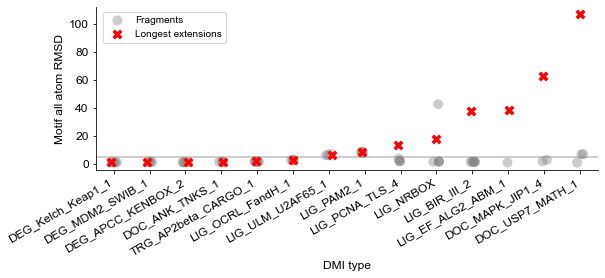

In [241]:
temp = ord_dis_df[ord_dis_df['superimposable'] == 1].sort_values('RMSD_all_atom_peptide_long').copy()
# temp1 = longest_ext_PRS[longest_ext_PRS['dmi_type'].isin(ord_dis_df[ord_dis_df['superimposable'] == 1].dmi_type)].sort_values('RMSD_all_atom_peptide').copy()
# temp = temp.melt(id_vars='dmi_type',value_vars=['RMSD_all_atom_peptide','RMSD_all_atom_peptide_long'])

fig, ax = plt.subplots(figsize=(9, 3))

sns.stripplot(data=temp,x='dmi_type', y='RMSD_all_atom_peptide', s=10,color='grey',marker='o',jitter=True,
              label='Fragments',ax=ax,alpha=0.4)
sns.stripplot(x=temp.dmi_type.unique(), y=temp.RMSD_all_atom_peptide_long.unique(), s=10,color='red',marker="X",
              jitter=True,label='Longest extensions',ax=ax)
plt.axhline(y=5,color=global_color,alpha=0.5)

# ax.set_yscale('log')
ax.set_ylabel('Motif all atom RMSD',fontsize=global_fontsize)
ax.set_xlabel('DMI type',fontsize=global_fontsize)
plt.yticks(fontsize=global_fontsize)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=global_fontsize,
                  rotation=30,ha='right')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=[handles[0],handles[-1]],labels=[labels[0],labels[-1]],bbox_to_anchor=(0.27,1))
plt.savefig(f'{save_path}PRS_fragments_above_threshold_full_length_RMSD.pdf',transparent=True,
            bbox_inches='tight')
plt.savefig(f'{save_path}PRS_fragments_above_threshold_full_length_RMSD.jpeg',transparent=True,dpi=300,
           bbox_inches='tight')
plt.show()

The point with high RMSD for LIG_NRBOX is run117_P03372_O_305_550.Q15596_D_377_1464 that detects another known instance in the chain and therefore scoring high confidence but poor RMSD.

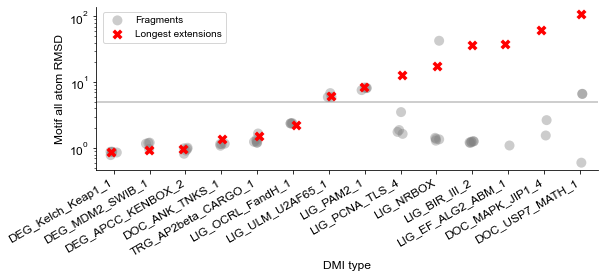

In [240]:
temp = ord_dis_df[ord_dis_df['superimposable'] == 1].sort_values('RMSD_all_atom_peptide_long').copy()
# temp1 = longest_ext_PRS[longest_ext_PRS['dmi_type'].isin(ord_dis_df[ord_dis_df['superimposable'] == 1].dmi_type)].sort_values('RMSD_all_atom_peptide').copy()
# temp = temp.melt(id_vars='dmi_type',value_vars=['RMSD_all_atom_peptide','RMSD_all_atom_peptide_long'])

fig, ax = plt.subplots(figsize=(9, 3))

sns.stripplot(data=temp,x='dmi_type', y='RMSD_all_atom_peptide', s=10,color='grey',marker='o',jitter=True,
              label='Fragments',ax=ax,alpha=0.4)
sns.stripplot(x=temp.dmi_type.unique(), y=temp.RMSD_all_atom_peptide_long.unique(), s=10,color='red',marker="X",
              jitter=True,label='Longest extensions',ax=ax)
plt.axhline(y=5,color=global_color,alpha=0.5)

ax.set_yscale('log')
ax.set_ylabel('Motif all atom RMSD',fontsize=global_fontsize)
ax.set_xlabel('DMI type',fontsize=global_fontsize)
plt.yticks(fontsize=global_fontsize)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=global_fontsize,
                  rotation=30,ha='right')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=[handles[0],handles[-1]],labels=[labels[0],labels[-1]],bbox_to_anchor=(0.27,1))
plt.savefig(f'{save_path}log_PRS_fragments_above_threshold_full_length_RMSD.pdf',transparent=True,
            bbox_inches='tight')
plt.savefig(f'{save_path}log_PRS_fragments_above_threshold_full_length_RMSD.jpeg',transparent=True,dpi=300,
           bbox_inches='tight')
plt.show()

In [162]:
temp1

,dmi_type,prediction_name,RMSD_all_atom_peptide,RMSD_backbone_peptide,DockQ,domain_ext_index,motif_ext_index
65,DOC_ANK_TNKS_1,run39_DOC_ANK_TNKS_1_M1_M322_D391_D742,1.397137,1.292120,0.931,2,5
118,TRG_AP2beta_CARGO_1,run40_TRG_AP2beta_CARGO_1_M38_M308_D4_D937,1.530464,0.907298,0.938,2,5
256,LIG_ULM_U2AF65_1,run39_LIG_ULM_U2AF65_1_M1_M140_D251_D475,6.123357,4.168887,0.625,2,5
16,DOC_USP7_MATH_1,run39_DOC_USP7_MATH_1_M290_M491_D1_D528,107.075668,106.919449,0.003,2,5
102,LIG_BIR_III_2,run39_LIG_BIR_III_2_M151_M416_D156_D497,37.359589,37.113708,0.023,2,5
68,DEG_MDM2_SWIB_1,run39_DEG_MDM2_SWIB_1_M1_M298_D1_D337,0.944391,0.573825,0.949,2,5
182,LIG_OCRL_FandH_1,run40_LIG_OCRL_FandH_1_M12_M249_D235_D901,2.247489,1.581665,0.892,2,5
35,DEG_Kelch_Keap1_1,run40_DEG_Kelch_Keap1_1_M1_M568_D175_D624,0.863355,0.465606,0.969,2,5
293,LIG_PAM2_1,run39_LIG_PAM2_1_M1_M127_D286_D636,8.449553,8.270999,0.395,2,5
137,LIG_NRBOX,run39_LIG_NRBOX_M453_M826_D174_D595,17.628992,17.032589,0.088,2,5


In [242]:
ext_PRS.dmi_type

0            LIG_LIR_Gen_1
1     LIG_LRP6_Inhibitor_1
2           LIG_NBox_RRM_1
3                LIG_NRBOX
4              LIG_Pex14_3
5        LIG_EF_ALG2_ABM_1
6                  LIG_GYF
7        DEG_APCC_KENBOX_2
8        DEG_Kelch_Keap1_1
9          DEG_MDM2_SWIB_1
10          DOC_ANK_TNKS_1
11         DOC_USP7_MATH_1
12           LIG_BIR_III_2
13         LIG_CNOT1_NIM_1
14        LIG_OCRL_FandH_1
15              LIG_PAM2_1
16          LIG_PCNA_TLS_4
17        LIG_ULM_U2AF65_1
18     TRG_AP2beta_CARGO_1
19         DOC_MAPK_JIP1_4
Name: dmi_type, dtype: object

Motif ext - domain ext
- DOC_ANK_TNKS_1: 5 x 2
- TRG_AP2beta_CARGO_1: FL-FL
- LIG_ULM_U2AF65_1: 5 x 2
- DOC_USP7_MATH_1: 5 x 2
- LIG_BIR_III_2: 5 x 2
- DEG_MDM2_SWIB_1: 5 x 2
- LIG_OCRL_FandH_1: 5 x 2
- DEG_Kelch_Keap1_1: 5 x 2
- LIG_PAM2_1: FL x 2
- LIG_NRBOX: 5 x 2
- LIG_PCNA_TLS_4: 5 x FL
- DOC_MAPK_JIP1_4: 5 x FL
- LIG_EF_ALG2_ABM_1: 5 x FL
- DEG_APCC_KENBOX_2: 5 x FL

6 more DMIs that are not in the plot due to either motif length is too long for full overlap or no fragment surviving the cutoff
- LIG_LIR_Gen_1: FL x FL
- LIG_LRP6_Inhibitor_1: Not FL x FL
- LIG_NBox_RRM_1: Not FL x FL
- LIG_Pex14_3: Not FL x FL
- LIG_GYF: Not FL x FL
- LIG_CNOT1_NIM_1: Not FL x FL

In [168]:
ord_dis_df

,project_name,prediction_name,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,...,metric,dmi_type,superimposable,RMSD_domain,RMSD_backbone_peptide,RMSD_all_atom_peptide,dmi_name,RMSD_all_atom_peptide_long,RMSD_backbone_peptide_long,DockQ_long
0,AlphaFold_benchmark_fragmentation,run118_O75381_O_25_75.P50542_D_538_548,51,11,ranked_0,0.835695,0.976900,0.972229,97.517895,0.130213,...,0.972229,LIG_Pex14_3,0,NaN,NaN,NaN,LIG_Pex14_3,3.038978,2.724523,0.769
1,AlphaFold_benchmark_fragmentation,run118_O75381_O_25_75.P50542_D_598_608,51,11,ranked_0,0.810602,0.972858,0.942929,96.183159,0.129566,...,0.942929,LIG_Pex14_3,0,NaN,NaN,NaN,LIG_Pex14_3,3.038978,2.724523,0.769
2,AlphaFold_benchmark_fragmentation,run118_O75381_O_25_75.P50542_D_493_503,51,11,ranked_0,0.804806,0.967457,0.940437,95.763182,0.230351,...,0.940437,LIG_Pex14_3,0,NaN,NaN,NaN,LIG_Pex14_3,3.038978,2.724523,0.769
3,AlphaFold_benchmark_fragmentation,run118_O75381_O_25_75.P50542_D_463_473,51,11,ranked_0,0.799780,0.966387,0.940014,95.799546,0.140345,...,0.940014,LIG_Pex14_3,0,NaN,NaN,NaN,LIG_Pex14_3,3.038978,2.724523,0.769
4,AlphaFold_benchmark_fragmentation,run118_O75381_O_25_75.P50542_D_563_593,51,31,ranked_0,0.750241,0.947845,0.907010,92.840000,0.193554,...,0.907010,LIG_Pex14_3,0,NaN,NaN,NaN,LIG_Pex14_3,3.038978,2.724523,0.769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,AlphaFold_benchmark_fragmentation,run115_O75581_D_3_12.O94907_O_181_266,10,86,ranked_0,0.656953,0.731717,0.935236,87.418000,0.098319,...,0.731717,LIG_LRP6_Inhibitor_1,0,NaN,NaN,NaN,LIG_LRP6_Inhibitor_1,66.860016,68.193497,0.007
566,AlphaFold_benchmark_fragmentation,run115_O75581_D_1572_1592.O94907_O_84_140,21,57,ranked_1,0.543372,0.730044,0.773804,76.149688,0.089290,...,0.730044,LIG_LRP6_Inhibitor_1,0,NaN,NaN,NaN,LIG_LRP6_Inhibitor_1,66.860016,68.193497,0.007
567,AlphaFold_benchmark_fragmentation,run115_O75581_D_1422_1432.O94907_O_84_140,11,57,ranked_0,0.641135,0.725460,0.869735,82.164333,0.261973,...,0.725460,LIG_LRP6_Inhibitor_1,0,NaN,NaN,NaN,LIG_LRP6_Inhibitor_1,66.860016,68.193497,0.007
568,AlphaFold_benchmark_fragmentation,run115_O75581_O_1248_1286.O94907_D_1_21,39,21,ranked_0,0.493100,0.840142,0.715070,78.329091,0.072768,...,0.715070,LIG_LRP6_Inhibitor_1,0,NaN,NaN,NaN,LIG_LRP6_Inhibitor_1,66.860016,68.193497,0.007


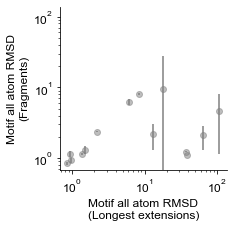

In [207]:
temp1 = longest_ext_PRS[longest_ext_PRS['dmi_type'].isin(ord_dis_df[ord_dis_df['superimposable'] == 1].dmi_type)].sort_values('dmi_type').copy()
temp2 = ord_dis_df[ord_dis_df['superimposable'] == 1].sort_values('dmi_type').copy()
temp2 = temp2.groupby('dmi_type').agg({'RMSD_all_atom_peptide':[('RMSD_all_atom_peptide_std','std'),
                                                     ('RMSD_all_atom_peptide_mean','mean')]})
temp = temp2['RMSD_all_atom_peptide'].reset_index().fillna(0).merge(temp1.rename({'RMSD_all_atom_peptide':'RMSD_all_atom_peptide_long',
                                                                          'RMSD_backbone_peptide':'RMSD_backbone_peptide_long',
                                                                          'DockQ':'DockQ_long'},axis=1))

fig, ax = plt.subplots(figsize=(3, 3))

plt.errorbar(x=temp['RMSD_all_atom_peptide_long'],y=temp['RMSD_all_atom_peptide_mean'],
             yerr=temp['RMSD_all_atom_peptide_std'],marker='',linestyle='',ecolor=global_color)
plt.scatter(x=temp['RMSD_all_atom_peptide_long'],y=temp['RMSD_all_atom_peptide_mean'],marker='o',
            color=global_color,alpha=0.5)

plt.yscale('log')
plt.xscale('log')
plt.ylim(ax.get_xlim())
plt.ylabel('Motif all atom RMSD\n(Fragments)',fontsize=global_fontsize)
plt.xlabel('Motif all atom RMSD\n(Longest extensions)',fontsize=global_fontsize)
plt.yticks(fontsize=global_fontsize)
plt.xticks(fontsize=global_fontsize)

plt.savefig(f'{save_path}PRS_fragments_above_threshold_full_length_mean_std_RMSD.pdf',transparent=True,
            bbox_inches='tight')
plt.savefig(f'{save_path}PRS_fragments_above_threshold_full_length_mean_std_RMSD.jpeg',transparent=True,dpi=300,
           bbox_inches='tight')
plt.show()

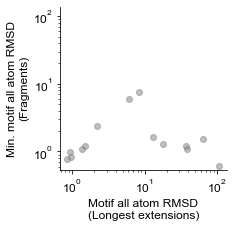

In [212]:
temp1 = longest_ext_PRS[longest_ext_PRS['dmi_type'].isin(ord_dis_df[ord_dis_df['superimposable'] == 1].dmi_type)].sort_values('dmi_type').copy()
temp2 = ord_dis_df[ord_dis_df['superimposable'] == 1].sort_values('dmi_type').copy()
temp2 = temp2.groupby('dmi_type').agg({'RMSD_all_atom_peptide':[('RMSD_all_atom_peptide_std','std'),
                                                                ('RMSD_all_atom_peptide_mean','mean'),
                                                                ('RMSD_all_atom_peptide_min','min')]})
temp = temp2['RMSD_all_atom_peptide'].reset_index().fillna(0).merge(temp1.rename({'RMSD_all_atom_peptide':'RMSD_all_atom_peptide_long',
                                                                          'RMSD_backbone_peptide':'RMSD_backbone_peptide_long',
                                                                          'DockQ':'DockQ_long'},axis=1))

fig, ax = plt.subplots(figsize=(3,3))

# plt.errorbar(x=temp['RMSD_all_atom_peptide_long'],y=temp['RMSD_all_atom_peptide_mean'],
#              yerr=temp['RMSD_all_atom_peptide_std'],marker='',linestyle='',ecolor=global_color)
plt.scatter(x=temp['RMSD_all_atom_peptide_long'],y=temp['RMSD_all_atom_peptide_min'],marker='o',
            color=global_color,alpha=0.5)

plt.yscale('log')
plt.xscale('log')
plt.ylim([ax.get_ylim()[0],ax.get_xlim()[-1]])
plt.ylabel('Min. motif all atom RMSD\n(Fragments)',fontsize=global_fontsize)
plt.xlabel('Motif all atom RMSD\n(Longest extensions)',fontsize=global_fontsize)
plt.yticks(fontsize=global_fontsize)
plt.xticks(fontsize=global_fontsize)

plt.savefig(f'{save_path}min_PRS_fragments_above_threshold_full_length_mean_std_RMSD.pdf',transparent=True,
            bbox_inches='tight')
plt.savefig(f'{save_path}min_PRS_fragments_above_threshold_full_length_mean_std_RMSD.jpeg',transparent=True,dpi=300,
           bbox_inches='tight')
plt.show()

In [209]:
temp

,dmi_type,RMSD_all_atom_peptide_std,RMSD_all_atom_peptide_mean,RMSD_all_atom_peptide_min,prediction_name,RMSD_all_atom_peptide_long,RMSD_backbone_peptide_long,DockQ_long,domain_ext_index,motif_ext_index
0,DEG_APCC_KENBOX_2,0.076968,0.941680,0.820771,run39_DEG_APCC_KENBOX_2_M1_M189_D1_D499,0.972427,0.807880,0.953,1,5
1,DEG_Kelch_Keap1_1,0.042058,0.856686,0.783529,run40_DEG_Kelch_Keap1_1_M1_M568_D175_D624,0.863355,0.465606,0.969,2,5
2,DEG_MDM2_SWIB_1,0.112065,1.137336,0.971619,run39_DEG_MDM2_SWIB_1_M1_M298_D1_D337,0.944391,0.573825,0.949,2,5
3,DOC_ANK_TNKS_1,0.036012,1.140163,1.087231,run39_DOC_ANK_TNKS_1_M1_M322_D391_D742,1.397137,1.292120,0.931,2,5
4,DOC_MAPK_JIP1_4,0.781477,2.107342,1.554754,run40_DOC_MAPK_JIP1_4_M29_M455_D1_D464,63.028614,61.740047,0.008,1,5
5,DOC_USP7_MATH_1,3.497650,4.639730,0.601054,run39_DOC_USP7_MATH_1_M290_M491_D1_D528,107.075668,106.919449,0.003,2,5
6,LIG_BIR_III_2,0.028743,1.240691,1.196028,run39_LIG_BIR_III_2_M151_M416_D156_D497,37.359589,37.113708,0.023,2,5
7,LIG_EF_ALG2_ABM_1,0.000000,1.098931,1.098931,run39_LIG_EF_ALG2_ABM_1_M403_M868_D1_D191,38.462318,36.877705,0.022,1,5
8,LIG_NRBOX,18.463297,9.623945,1.297173,run39_LIG_NRBOX_M453_M826_D174_D595,17.628992,17.032589,0.088,2,5
9,LIG_OCRL_FandH_1,0.011406,2.377346,2.368082,run40_LIG_OCRL_FandH_1_M12_M249_D235_D901,2.247489,1.581665,0.892,2,5


In [202]:
temp1.to_csv('/Volumes/imb-luckgr/manuscripts/AlphaFold_paper/tables/fragmentation_benchmark_PRS_long_extensions.tsv',sep='\t')
temp2 = ord_dis_df[ord_dis_df['superimposable'] == 1].copy()
temp2.to_csv('/Volumes/imb-luckgr/manuscripts/AlphaFold_paper/tables/fragmentation_benchmark_PRS_above_threshold_superimposable.tsv',sep='\t')